In [1]:
#pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
churn_data = pd.read_csv("Telco_customer_churn.csv")

In [4]:
churn_data.head(10)
churn_data.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

# Data cleanup: Filtering out non-usable columns from data
We notice that the columns at the end - Churn Value, Churn Score, CLTV, Churn Reason come from exit interview when a person leaves the company.
So, these will give us perfect predictability if we don't remove them from the dataset

Also, some of the other columns like Count, Country , State have single value in them and hence can be removed.

Apart from this, ID column has unique value for every row, hence useless for the model.
Also, notice that the column 'Lat Long' is not required as wel have Latiude and Longitude separately present in the data.

In [5]:
churn_data.drop(['Churn Value', 'Churn Score', 'CLTV', 'Churn Reason'], axis = 1, inplace = True)
churn_data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes


In [6]:
print(churn_data['Count'].unique())
print(churn_data['Country'].unique())
print(churn_data['State'].unique())

## Dropping extra columns
churn_data.drop(['CustomerID', 'Count', 'Country','State', 'Lat Long'], axis = 1, inplace=True)
churn_data.head()

[1]
['United States']
['California']


,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes


In [7]:
## NOTE: The tree that we will create does not support white spaces in the values of any of the columns - Since City has blank spaces so we replace them with _
print(churn_data['City'].unique()[0:5])
churn_data['City'].replace(' ', '_', regex=True, inplace=True)
print(churn_data['City'].unique()[0:5])

['Los Angeles' 'Beverly Hills' 'Huntington Park' 'Lynwood'
 'Marina Del Rey']
['Los_Angeles' 'Beverly_Hills' 'Huntington_Park' 'Lynwood'
 'Marina_Del_Rey']


In [8]:
## Also replace the white spaces with _ in the column names
churn_data.columns = churn_data.columns.str.replace(' ','_', regex = True)

# Missing Data: Identifying Missing Data

In [9]:
## First check the types of columns in the data
print(churn_data.dtypes)
print(churn_data.describe())

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Label           object
dtype: object
           Zip_Code     Latitude    Longitude  Tenure_Months  Monthly_Charges
count   7043.000000  7043.000000  7043.000000    7043.000000      7043.000000
mean   93521.964646    36.282441  -119.798880      32.371149        64.761692
std     1865.794555     2.455723     2.157889      24.55

In [10]:
## Check for NAs, NaNs in the data
(churn_data.isnull()).sum()

City                 0
Zip_Code             0
Latitude             0
Longitude            0
Gender               0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure_Months        0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn_Label          0
dtype: int64

In [11]:
churn_data.isna().any()

City                 False
Zip_Code             False
Latitude             False
Longitude            False
Gender               False
Senior_Citizen       False
Partner              False
Dependents           False
Tenure_Months        False
Phone_Service        False
Multiple_Lines       False
Internet_Service     False
Online_Security      False
Online_Backup        False
Device_Protection    False
Tech_Support         False
Streaming_TV         False
Streaming_Movies     False
Contract             False
Paperless_Billing    False
Payment_Method       False
Monthly_Charges      False
Total_Charges        False
Churn_Label          False
dtype: bool

In [12]:
## We notice that one column - Total Charges has the datatype object while it should be numeric. 
## When we try to convert it to numeric type, it gives an error and that gives us an idea as to what could be causing 
#churn_data['Total_Charges'] = pd.to_numeric(churn_data['Total_Charges'])

## We get the error - ValueError: Unable to parse string " " at position 2234

# So, print the value at 2234:
churn_data.loc[2234,'Total_Charges']

' '

# Missing Data: Dealing with Missing Data, XGBoost style

Note that XGBoost itself has a way to deal with missing values. One thing relatively unique about it is that it determines default behaviour for missing data. All we have to do is: 
<b> Identify missing values and make sure they are set to 0.</b>

However, before we start, we need to check how many rows have missing data. If it's a lot, then we might have a problem that is bigger than what XGBoost can solve. Otherwise, we can set them to 0.

In [13]:
print(len(churn_data['Total_Charges']))
print(len(churn_data[churn_data['Total_Charges'] == ' ']))


## Set these white spaces to 0 and then convert the column to numeric
churn_data.loc[churn_data['Total_Charges'] == ' ', 'Total_Charges'] = 0

7043
11


In [14]:
churn_data['Total_Charges'] = churn_data['Total_Charges'].astype(float)

## Check the rows where Tenure_Months is 0. Whosoever has just started with the plan, hasn't paid any charges yet.
## Hence resulted in missing value in Total Charges column.
churn_data.loc[churn_data['Tenure_Months'] == 0, ['Total_Charges']]

,Total_Charges
2234,0.0
2438,0.0
2568,0.0
2667,0.0
2856,0.0
4331,0.0
4687,0.0
5104,0.0
5719,0.0
6772,0.0


In [15]:
## NOw, we will replace all the blank spaces in the whole dataset with _

churn_data.replace(' ','_', regex = True, inplace=True)
churn_data.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,Yes
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,Yes
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,Yes


# Separate data into train and test sets

In [16]:
X = churn_data.drop('Churn_Label', axis = 'columns').copy()
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [17]:
y = churn_data['Churn_Label'].copy()
y.head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: Churn_Label, dtype: object

In [18]:
## Identify and display the names of the non-numeric columns
non_numeric_columns = X.select_dtypes(exclude = 'number').columns
non_numeric_columns

Index(['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method'],
      dtype='object')

# One-hot-encoding to encode the categorical columns
Note that the tree based algorithms cannot natively handle categorical data, so we have to encode all the categorical columns using either pd.get_dummies or using sklearn.compose.ColumnTransformer

In [19]:
X = pd.get_dummies(X, columns = ['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service',
       'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method'])
print(X.head())

   Zip_Code   Latitude   Longitude  Tenure_Months  Monthly_Charges  \
0     90003  33.964131 -118.272783              2            53.85   
1     90005  34.059281 -118.307420              2            70.70   
2     90006  34.048013 -118.293953              8            99.65   
3     90010  34.062125 -118.315709             28           104.80   
4     90015  34.039224 -118.266293             49           103.70   

   Total_Charges  City_Acampo  City_Acton  City_Adelanto  City_Adin  ...  \
0         108.15            0           0              0          0  ...   
1         151.65            0           0              0          0  ...   
2         820.50            0           0              0          0  ...   
3        3046.05            0           0              0          0  ...   
4        5036.30            0           0              0          0  ...   

   Streaming_Movies_Yes  Contract_Month-to-month  Contract_One_year  \
0                     0                        1   

In [20]:
## Convert Yes = Left =1 , No (Did not leave) =0 in the dependent variable

y[y=='Yes'] = 1
y[y=='No'] = 0
print(y.unique())
print(type(y))
print(y.dtypes)
y = y.astype(int)
#y.isnull().sum()

[1 0]
<class 'pandas.core.series.Series'>
object


# Build a preliminary XGBoost model

The next step is to first check if there is any imbalance in the classes to be predicted <br/>
Then split the data into train and test sets <br/>
Then, build the basic XGBoost tree <br/>

In [21]:
## Check the % of each class - 0 & 1 in y
sum(y)/len(y)

0.2653698707936959

# Imbalanced classes so use stratification while splitting into train & test datasets

Note that only 27% of the people left the company in the data provided. <br/>
In order to maintain the same % of class distribution in both train & test datasets, we set stratify to yes.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, random_state = 42)

In [23]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.2654297614539947
0.26519023282226006


In [24]:
## Create the shell for XGBoost tree
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', missing = np.nan, seed=42, eval_metric = 'aucpr', early_stopping_rounds = 10)

## In place of using cross validation for optimization, we are using early_stopping_rounds as 10
## This means that the trees are no more built if the prediction doesn't improve then tree building stops after 10 more trees are created
## We are using auc metric to evaluate
xgb_clf = xgb_clf.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=True)

[0]	validation_0-aucpr:0.64135
[1]	validation_0-aucpr:0.65171
[2]	validation_0-aucpr:0.65991
[3]	validation_0-aucpr:0.65350
[4]	validation_0-aucpr:0.65743
[5]	validation_0-aucpr:0.65051
[6]	validation_0-aucpr:0.65827
[7]	validation_0-aucpr:0.65980
[8]	validation_0-aucpr:0.65751
[9]	validation_0-aucpr:0.65389
[10]	validation_0-aucpr:0.65572
[11]	validation_0-aucpr:0.65920
[12]	validation_0-aucpr:0.66010
[13]	validation_0-aucpr:0.65963
[14]	validation_0-aucpr:0.65877
[15]	validation_0-aucpr:0.65791
[16]	validation_0-aucpr:0.65808
[17]	validation_0-aucpr:0.65742
[18]	validation_0-aucpr:0.65770
[19]	validation_0-aucpr:0.65698
[20]	validation_0-aucpr:0.65733
[21]	validation_0-aucpr:0.65646


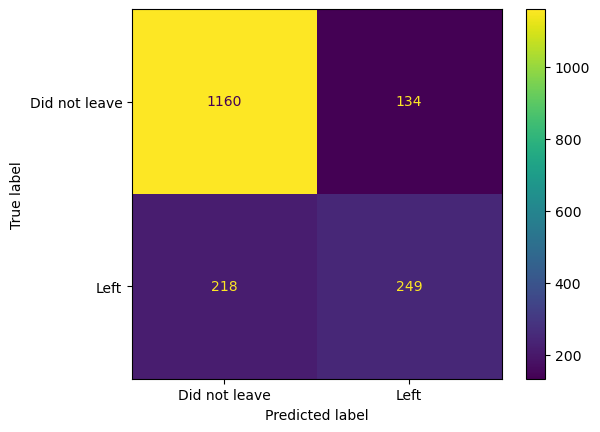

In [25]:
## Let's see how it performs on the test dataset by creating CONFUSION MATRIX
y_pred = xgb_clf.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred)

cm_xgb_display = ConfusionMatrixDisplay(cm_xgb, display_labels = ['Did not leave','Left'])
cm_xgb_display.plot()

We notice that almost 90% of people who did not leave were correctly classified but only ~50% of people who left were correctly classified. Because people leaving the company costs them a lot of money so we would want the model to classify them better.<br/>

XGBoost has a parameter called <b>scale_pos_weight</b> to balance out the imbalanced classes. We will use this parameter along with cross validation on other hyper parameters to improve the model.</br>

# Optimize the XGBoost model 
We try to use different parameters for max_depth (tree depth), learning rate or eta, gamma that encourages pruning to overcome overfitting, reg_lambda which is the regularization parameter lambda.<br/>

NOTE: When data are imbalanced, the XGBoost manual says -<br/>
1. If you care about overall prediction metric (AUC) of your prediction, then use scale_pos_weight to balance the data
2. Use AUC for evaluation

In [27]:
# ROUND 1
# param_grid = {
#     'max_depth' : [3,4,5],
#     'learning_rate' : [0.1,0.01,0.05],
#     'gamma' : [0,0.25,1],
#     'reg_lambda' : [0,1,10],
#     'scale_pos_weight' : [1,3,5] ## XGBoost manual suggests using sum(negative_instances/sum(positive_instances))
# }


# ROUND 2
param_grid = {
    'max_depth' : [4],
    'learning_rate' : [0.1,0.5,1],
    'gamma' : [0.25],
    'reg_lambda' : [10,20,100],
    'scale_pos_weight' : [3]
}

#{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 3}

# NOTE: To speed up cross validation and prevent overfitting, we only use random subset (90%) of the data & 50% of column/feature subset
optimal_params = GridSearchCV(
        estimator = xgb.XGBClassifier(objective = 'binary:logistic', 
                                      subsample = 0.9, 
                                      colsample_bytree = 0.5),
                                      param_grid = param_grid,
                                      scoring = 'roc_auc',
                                      n_jobs=10,
                                      cv=3
                                     )

optimal_params.fit(X_train, y_train,
                  early_stopping_rounds = 10,
                  eval_metric = 'aucpr',
                  eval_set = [(X_test, y_test)],
                  verbose = False)

print(optimal_params.best_params_)

/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_

/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 3}


# Building, evaluating, interpreting the optimized tree
Now that we have the ideal parameters, we can build the final model

In [28]:
xgb_final = xgb.XGBClassifier(objective = 'binary:logistic', 
                                      gamma = 0.25,
                                      learn_rate = 0.1,
                                      reg_lambda = 10,
                                      max_depth = 4,
                                      early_stopping_rounds = 10,
                                      eval_metric = 'aucpr',
                                      subsample = 0.9, 
                                      colsample_bytree = 0.5)

xgb_final  = xgb_final.fit(X_train, y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.58423
[1]	validation_0-aucpr:0.60653
[2]	validation_0-aucpr:0.62219
[3]	validation_0-aucpr:0.63026
[4]	validation_0-aucpr:0.65251
[5]	validation_0-aucpr:0.64989
[6]	validation_0-aucpr:0.64936
[7]	validation_0-aucpr:0.65311
[8]	validation_0-aucpr:0.65250
[9]	validation_0-aucpr:0.65938
[10]	validation_0-aucpr:0.65819
[11]	validation_0-aucpr:0.66564
[12]	validation_0-aucpr:0.66645
[13]	validation_0-aucpr:0.66657
[14]	validation_0-aucpr:0.66851
[15]	validation_0-aucpr:0.66623


/Users/rahularora/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:58:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/learner.cc:742: 
Parameters: { "learn_rate" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-aucpr:0.66805
[17]	validation_0-aucpr:0.66725
[18]	validation_0-aucpr:0.66745
[19]	validation_0-aucpr:0.66606
[20]	validation_0-aucpr:0.66631
[21]	validation_0-aucpr:0.66573
[22]	validation_0-aucpr:0.66389
[23]	validation_0-aucpr:0.66326


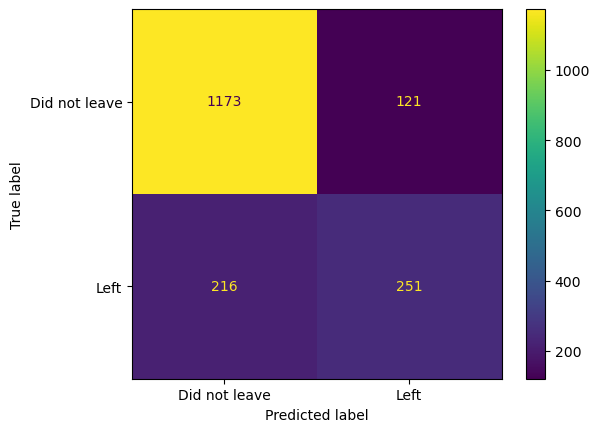

In [30]:
## Let's see how it performs on the test dataset by creating CONFUSION MATRIX
y_pred_final = xgb_final.predict(X_test)
cm_xgb_final = confusion_matrix(y_test, y_pred_final)

cm_final_display = ConfusionMatrixDisplay(cm_xgb_final, display_labels = ['Did not leave','Left'])
cm_final_display.plot()